# Traveling salesman problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv('cities.csv')

## Data preprocessing

In [3]:
data = data.drop([923])

In [4]:
data['population'] = data['Население'].apply(lambda x: int(x))

In [5]:
cities = data.sort_values(by='population', ascending=False).iloc[:30]

In [6]:
cities.at[506, 'Город'] = 'Москва'
cities.at[782, 'Город'] = 'Санкт-Петербург'

In [7]:
cities = cities[['Город', 'Широта', 'Долгота', 'population']]

In [8]:
cities.columns = ['name', 'latitude', 'longitude', 'popolation']

In [9]:
cities

,name,latitude,longitude,popolation
506,Москва,55.753879,37.620373,11514330
782,Санкт-Петербург,59.939125,30.315822,4848742
643,Новосибирск,55.028102,82.921057,1498921
828,Екатеринбург,56.838633,60.605489,1377738
615,Нижний Новгород,56.324209,44.005395,1250615
924,Казань,55.794388,49.111531,1216965
778,Самара,53.195166,50.106769,1164900
652,Омск,54.984814,73.367464,1154000
1060,Челябинск,55.160366,61.400786,1130273
753,Ростов-на-Дону,47.222436,39.718787,1091544


In [10]:
!pip install geopy

You are using pip version 18.0, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [10]:
from geopy.distance import geodesic, great_circle

## The algorithm

In [11]:
def get_distance(path):
    dist = 0
    
    for i in range(len(path) - 1):
        town1 = cities.loc[path[i]]
        town2 = cities.loc[path[i + 1]]
        
        arg1 = town1['latitude'], town1['longitude']
        arg2 = town2['latitude'], town2['longitude']
        
        dist += geodesic(arg1, arg2).km
        
    town1 = cities.loc[path[0]]
    town2 = cities.loc[path[-1]]

    arg1 = town1['latitude'], town1['longitude']
    arg2 = town2['latitude'], town2['longitude']

    dist += geodesic(arg1, arg2).km
    
    return dist

In [12]:
def modify_path(path):
    copy = list(path)
    idx = range(len(copy))
    i1, i2 = random.sample(idx, 2)
    copy[i1], copy[i2] = copy[i2], copy[i1]
    
    return copy

In [59]:
def get_energy(distance, T):
    return np.exp(- np.log(distance) / T)

In [63]:
def simulate_annealing(start_path, start_temp=10, temp_rate=0.95, track_path_history=False):
    current_path = start_path
    current_distance = get_distance(current_path)
    T = start_temp
    distance_history = []
    path_history = []
    
    
    counter = 0

    while T > 1e-12:
        
        if track_path_history:
            path_history.append(current_path)
        
        if counter % 100 == 0:
            print('Step number {}. Temperature is {}, distance is {}'.format(counter, T, current_distance))

        new_path = modify_path(current_path)
        new_distance = get_distance(new_path)

        if new_distance < current_distance or random.random() <= get_energy(new_distance, T) / get_energy(current_distance, T):
            current_path = new_path
            current_distance = new_distance
            distance_history.append(new_distance)

        T *= temp_rate    

        counter += 1
        
    if track_path_history:
        return path_history
        
    return counter, current_distance, current_path, distance_history

In [64]:
n_steps_fast, distance_fast, path_fast, distances_fast = simulate_annealing(list(cities.index), 10, temp_rate=0.95)

Step number 0. Temperature is 10, distance is 65359.137447908724
Step number 100. Temperature is 0.05920529220334, distance is 55133.231605358545


C:\Conda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Step number 200. Temperature is 0.0003505266624882867, distance is 35664.867794081634
Step number 300. Temperature is 2.075303347768052e-06, distance is 30069.913528458972
Step number 400. Temperature is 1.2286894111517731e-08, distance is 29109.925803084916
Step number 500. Temperature is 7.274491561439047e-11, distance is 24710.3492436187


In [15]:
def plot_path(path):
    ordered_lat = []
    ordered_long = []

    for i in range(len(path)):
        town = cities.loc[path[i]]

        ordered_lat.append(town['latitude'])
        ordered_long.append(town['longitude'])

    town = cities.loc[path[0]]

    ordered_lat.append(town['latitude'])
    ordered_long.append(town['longitude'])
    
    fig, ax = plt.subplots()

    ax.scatter(cities['longitude'], cities['latitude'])
    ax.plot(ordered_long, ordered_lat)
    
    for i in range(len(path)):
        town = cities.loc[path[i]]
        ax.annotate(town['name'], (town['longitude'], town['latitude']))
                    
    plt.show()

In [16]:
def get_ordered_coordinates(path):
    ordered_lat = []
    ordered_long = []

    for i in range(len(path)):
        town = cities.loc[path[i]]

        ordered_lat.append(town['latitude'])
        ordered_long.append(town['longitude'])

    town = cities.loc[path[0]]

    ordered_lat.append(town['latitude'])
    ordered_long.append(town['longitude'])
    
    return ordered_lat, ordered_long

## Run the algorithm with different cooling rates

In [78]:
n_steps_fast, distance_fast, path_fast, distances_fast = simulate_annealing(list(cities.index), 10, temp_rate=0.95)

Step number 0. Temperature is 10, distance is 65359.137447908724
Step number 100. Temperature is 0.05920529220334, distance is 40626.26418004172


C:\Conda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Step number 200. Temperature is 0.0003505266624882867, distance is 29390.443362299433
Step number 300. Temperature is 2.075303347768052e-06, distance is 28377.54451608237
Step number 400. Temperature is 1.2286894111517731e-08, distance is 26129.175953567257
Step number 500. Temperature is 7.274491561439047e-11, distance is 24969.993374206497


In [74]:
n_steps_med, distance_med, path_med, distances_med = simulate_annealing(list(cities.index), 10, temp_rate=0.99)

Step number 0. Temperature is 10, distance is 65359.137447908724
Step number 100. Temperature is 3.660323412732291, distance is 61692.59120385109
Step number 200. Temperature is 1.339796748579617, distance is 63889.292153277114
Step number 300. Temperature is 0.49040894071285696, distance is 71353.41066373391
Step number 400. Temperature is 0.17950553275045117, distance is 64129.61284693256
Step number 500. Temperature is 0.06570483042414595, distance is 55431.84349352631
Step number 600. Temperature is 0.024050092913110634, distance is 41744.06356903719


C:\Conda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Step number 700. Temperature is 0.008803111816824588, distance is 36333.703399609825
Step number 800. Temperature is 0.003222223628802333, distance is 30715.599157278943
Step number 900. Temperature is 0.0011794380589564384, distance is 25347.703321816276
Step number 1000. Temperature is 0.0004317124741065781, distance is 25346.7053794498
Step number 1100. Temperature is 0.00015802072765408906, distance is 24813.660226017255
Step number 1200. Temperature is 5.7840696912925543e-05, distance is 24813.660226017255
Step number 1300. Temperature is 2.117156571191338e-05, distance is 24789.07137117025
Step number 1400. Temperature is 7.749477765951677e-06, distance is 24789.07137117025
Step number 1500. Temperature is 2.836559490316126e-06, distance is 24789.07137117025
Step number 1600. Temperature is 1.0382725114012092e-06, distance is 24789.07137117025
Step number 1700. Temperature is 3.800413182278202e-07, distance is 24553.391495846987
Step number 1800. Temperature is 1.391074134914934e

In [67]:
n_steps_low, distance_low, path_low, distances_low = simulate_annealing(list(cities.index), 10, temp_rate=0.995)

Step number 0. Temperature is 10, distance is 65359.137447908724
Step number 100. Temperature is 6.057704364907275, distance is 69295.99657380367
Step number 200. Temperature is 3.6695782172616735, distance is 63312.26664763382
Step number 300. Temperature is 2.2229219984074717, distance is 56143.91625600843
Step number 400. Temperature is 1.3465804292601349, distance is 69569.31560050431
Step number 500. Temperature is 0.8157186144027834, distance is 59343.409477341964
Step number 600. Temperature is 0.4941382211003862, distance is 57362.3179256439
Step number 700. Temperature is 0.29933432588273284, distance is 48966.25907217227
Step number 800. Temperature is 0.1813278852466409, distance is 60758.136358802156
Step number 900. Temperature is 0.10984307219379826, distance is 51135.47586311353
Step number 1000. Temperature is 0.06653968578831973, distance is 46703.18532888609
Step number 1100. Temperature is 0.04030777450394634, distance is 54788.85282084931
Step number 1200. Temperatu

C:\Conda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Step number 1400. Temperature is 0.008960103865167005, distance is 32374.206155234882
Step number 1500. Temperature is 0.005427766029404476, distance is 30259.858222805673
Step number 1600. Temperature is 0.003287980196801894, distance is 27737.012630559988
Step number 1700. Temperature is 0.001991761198989554, distance is 27247.02606998168
Step number 1800. Temperature is 0.0012065500508971977, distance is 26330.14386832893
Step number 1900. Temperature is 0.000730892350979905, distance is 25703.794564347954
Step number 2000. Temperature is 0.00044275297848083144, distance is 23706.530139296287
Step number 2100. Temperature is 0.000268206665031903, distance is 23129.42914589144
Step number 2200. Temperature is 0.0001624716685460984, distance is 22224.547605333362
Step number 2300. Temperature is 9.842053357254689e-05, distance is 21994.717980431255
Step number 2400. Temperature is 5.9620249581892095e-05, distance is 21810.4651203275
Step number 2500. Temperature is 3.6116184612908915e

## Visualization

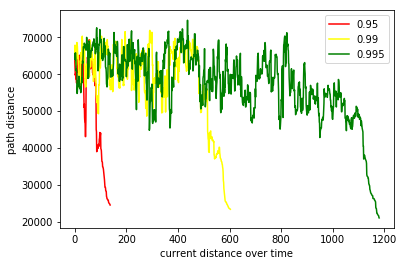

In [80]:
plt.plot(distances_fast, color='red', label="0.95")
plt.plot(distances_med, color='yellow', label="0.99")
plt.plot(distances_low, color='green', label="0.995")
plt.legend(loc="upper right")
plt.xlabel('current distance over time')
plt.ylabel('path distance')
plt.show()

In [69]:
def subplot_path(ax, path, label):
    ax.scatter(cities['longitude'], cities['latitude'])
    
    ordered_lat, ordered_long = get_ordered_coordinates(path)
    
    ax.plot(ordered_long, ordered_lat)
    ax.title.set_text(label)

    for i in range(len(path)):
        town = cities.loc[path[i]]
        ax.annotate(town['name'], (town['longitude'], town['latitude']))    

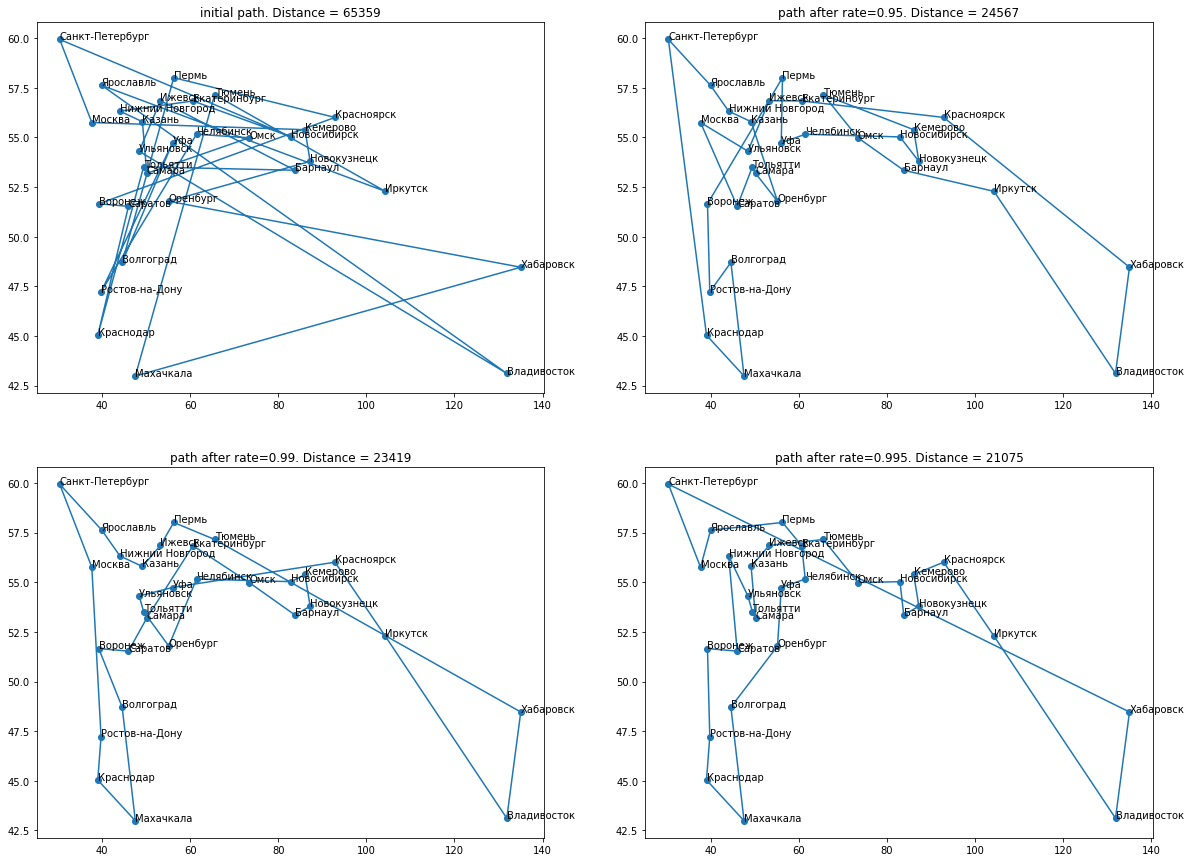

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

subplot_path(axes[0][0], list(cities.index), 'initial path. Distance = ' + str(int(get_distance(list(cities.index)))))
subplot_path(axes[0][1], path_fast, 'path after rate=0.95. Distance = ' + str(int(distance_fast)))
subplot_path(axes[1][0], path_med, 'path after rate=0.99. Distance = ' + str(int(distance_med)))
subplot_path(axes[1][1], path_low, 'path after rate=0.995. Distance = ' + str(int(distance_low)))

plt.show()

## Make some dumps to make animation

In [26]:
from matplotlib.animation import FuncAnimation

In [44]:
h = simulate_annealing(list(cities.index), 10, temp_rate=0.95, track_path_history=True)

Step number 0. Temperature is 10, distance is 65359.137447908724


C:\Conda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Step number 100. Temperature is 0.05920529220334, distance is 37248.90667788756
Step number 200. Temperature is 0.0003505266624882867, distance is 29083.357318241164
Step number 300. Temperature is 2.075303347768052e-06, distance is 27932.67044765275
Step number 400. Temperature is 1.2286894111517731e-08, distance is 27023.429223935836
Step number 500. Temperature is 7.274491561439047e-11, distance is 25926.992667800074


In [47]:
vis_dump = []

for path in h:
    lat, long = get_ordered_coordinates(path)
    
    vis_dump.append([lat, long])

In [48]:
dump = np.array(vis_dump)

In [49]:
np.save('data.npy', dump)

In [42]:
cities['name'].to_csv('names.csv', encoding='utf-16')